In [1]:
# !pip install scikit-learn

### Import modułów
Moduły wykorzystywane w projekcie:
* **numpy, pandas** - gromadzenie i porządkowanie danych
* **matplotlib.pyplot** - wizualizacja danych
* **sklearn (z pakietu scikit-learn)** - rozbudowane narzędzie do m.in *machine learningu*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity#, linear_kernel

import time

### Zebranie danych
Za jedyne źródło danych posłużył dataset <a href="https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset" target="_blank">*The Movies Dataset*</a> ze strony *kaggle.com*. </br>
Posiada ponad 45 000 rekordów z przeróżnymi informacjami na temat filmów. W tym przypadku istotne będą jedynie kolumny z **tytułami** i **opisami**.
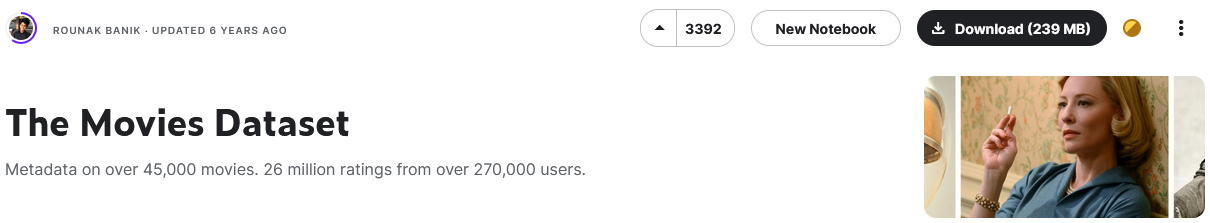

In [3]:
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
# Tylko tytuł i opisy są dla nas istotne. Imdb_id użyjemy do rozróżniania duplikatów
movies = movies[['title', 'overview', 'imdb_id']]

print(movies.head())
print('Ilość rekordów: ', movies.shape[0])

                         title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview    imdb_id  
0  Led by Woody, Andy's toys live happily in his ...  tt0114709  
1  When siblings Judy and Peter discover an encha...  tt0113497  
2  A family wedding reignites the ancient feud be...  tt0113228  
3  Cheated on, mistreated and stepped on, the wom...  tt0114885  
4  Just when George Banks has recovered from his ...  tt0113041  
Ilość rekordów:  45466


### Preprocessing danych
Przed analizą musimy oczyścić dane. Jako, że nasz Data Frame zawiera tylko dwie kolumny, nie ma wiele do zrobienia.
Usuniemy rekordy z pustymi wartościami, oraz duplikaty.

In [4]:
# Szukamy pustych rekordów i je usuwamy
missing_values = movies.isna().sum().sort_values()
print("Przed czyszczeniem:\n", missing_values)

movies.dropna(inplace=True)

missing_values_cleaned = movies.isna().sum().sort_values()
print("Po czyszczeniu:\n", missing_values_cleaned)

# Przydatne do wizualizacji
missing_data = {
    'Tytuły': (missing_values[0], missing_values_cleaned[0]),
    'imdb_id': (missing_values[1], missing_values_cleaned[1]),
    'Opisy': (missing_values[2], missing_values_cleaned[2])
}

print('Pozostało {} rekordów'.format(movies.shape[0]))

Przed czyszczeniem:
 title         6
imdb_id      17
overview    954
dtype: int64
Po czyszczeniu:
 title       0
overview    0
imdb_id     0
dtype: int64
Pozostało 44491 rekordów


In [5]:
# Szukamy duplikatów i tworzymy z nich Data Frame
duplicates_ = movies.duplicated(subset=['title', 'imdb_id'], keep=False)
duplicates = movies[duplicates_].sort_values(by='title').copy().reset_index(drop=True)
print(duplicates.head())

# Usuwanie duplikatów (zakładamy, że niemożliwym jest, że istnieją dwa filmy o takim samym tytule i imdb_id)
row_count_duplicates = movies.shape[0]

movies.drop_duplicates(subset=['title', 'imdb_id'], keep=False, inplace=True)

row_count_no_duplicates = movies.shape[0]

duplicates_prcs = row_count_no_duplicates/row_count_duplicates

print('Usunięto {} duplikatów'.format(row_count_duplicates - row_count_no_duplicates))
print('Pozostało {} rekordów'.format(movies.shape[0]))

                  title                                           overview  \
0    A Farewell to Arms  British nurse Catherine Barkley (Helen Hayes) ...   
1    A Farewell to Arms  British nurse Catherine Barkley (Helen Hayes) ...   
2  A Place at the Table  Using personal stories, this powerful document...   
3  A Place at the Table  Using personal stories, this powerful document...   
4            Black Gold  On the Arabian Peninsula in the 1930s, two war...   

     imdb_id  
0  tt0022879  
1  tt0022879  
2  tt1736049  
3  tt1736049  
4  tt1701210  
Usunięto 59 duplikatów
Pozostało 44432 rekordów


### Wizualizacja wpływu preprocessingu

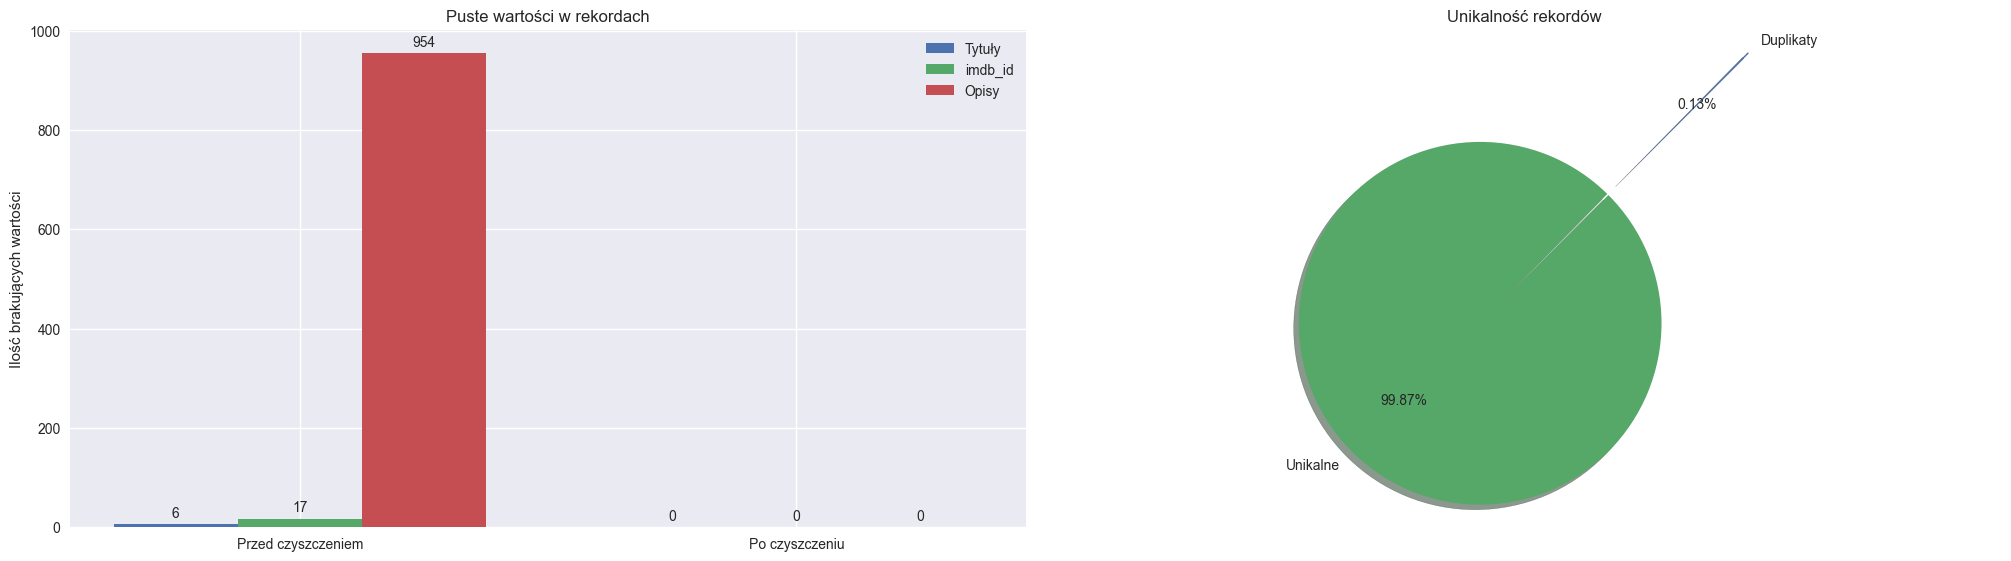

In [6]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2, layout='constrained')
fig.set_figwidth(20)

# Bar chart dla czyszczenia danych
labels_bar = ('Przed czyszczeniem', 'Po czyszczeniu')
x = np.arange(len(labels_bar))
width = 0.25
multiplier = 0

for col, missing_sum in missing_data.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, missing_sum, width, label=col)
    ax[0].bar_label(rects, padding=3)
    multiplier += 1

ax[0].set_title('Puste wartości w rekordach')
ax[0].set_ylabel('Ilość brakujących wartości')
ax[0].set_xticks(x + width, labels_bar)
ax[0].legend(loc='upper right', ncols=1)

# Pie chart dla duplikatów
labels_pie = ('Duplikaty', 'Unikalne')
sizes_pie = [1 - duplicates_prcs, duplicates_prcs]
explode =(0.1, 1)
ax[1].pie(sizes_pie, labels=labels_pie, explode=explode, shadow=True, startangle=45, autopct='%0.2f%%')
ax[1].axis('equal')
ax[1].set_title('Unikalność rekordów')

plt.show()

### Wektor Tf-idf 
**Tf-idf** Term Frequency-Inverse Document Frequency - technika używana w NLP.
Mierzy ważność słów w kontekście dokumentu w zbiorze dokumentów.

**TF (Term Frequency)**: Mierzy, jak często dany termin występuje w dokumencie. Jest to stosunek liczby wystąpień danego słowa do liczby wszystkich słów w dokumencie. </br>
$$ 
\begin{align}
\frac{\text{Wystapienie słowa}}{\text{Liczba słów w dokumencie}}
\end{align}
$$

**IDF (Inverse Document Frequency)**: Określa, jak istotne jest dane słowo w kontekście całego zbioru dokumentów. Wartość IDF rośnie, gdy słowo występuje rzadko we wszystkich dokumentach w zbiorze. </br>
$$ 
\begin{align}
\log(\frac{\text{W ilu dokumentach wystąpiło słowo}}{\text{Liczba dokumentów}})
\end{align}
$$


In [7]:
# TODO: ustawić parametry np. min_df, max_df, stopwords
tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(movies['overview'].values)

### Podobieństwo cosiunowe (Cosine similarity)
Podobieństwo cosinusowe (cosine similarity) to miara używana w analizie tekstu do oceny stopnia podobieństwa między dwoma wektorami reprezentującymi teksty.
Mierzy kąt między tymi wektorami w wielowymiarowej przestrzeni, przy czym niższy kąt oznacza większe podobieństwo. </br>
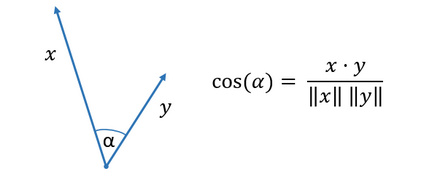

In [8]:
# Macierz stworzona przy użyciu 'cosine similarity'
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print('Ilość wierszy: {}\nIlość kolumn: {}'.format(*cosine_sim_matrix.shape))

# Macierz przedstawia kombinację podobieństwa wszystkich filmów (opisów)
movies_cosine = pd.DataFrame(cosine_sim_matrix, index=movies['title'].values, columns=movies['title'].values)
print(movies_cosine.head())

Ilość wierszy: 44432
Ilość kolumn: 44432
                             Toy Story   Jumanji  Grumpier Old Men  \
Toy Story                     1.000000  0.030690          0.012836   
Jumanji                       0.030690  1.000000          0.056751   
Grumpier Old Men              0.012836  0.056751          1.000000   
Waiting to Exhale             0.014755  0.038782          0.044938   
Father of the Bride Part II   0.030788  0.037573          0.056640   

                             Waiting to Exhale  Father of the Bride Part II  \
Toy Story                             0.014755                     0.030788   
Jumanji                               0.038782                     0.037573   
Grumpier Old Men                      0.044938                     0.056640   
Waiting to Exhale                     1.000000                     0.027950   
Father of the Bride Part II           0.027950                     1.000000   

                                 Heat   Sabrina  Tom and Huck  

### Funkcje do wyszukiwania/wyświetlania wyników

In [38]:
# Funkcja wyszukująca
def find_similar_to(title=''):
    similiarities = movies_cosine.loc[title]
    # Ucinamy pierwszy element - zawiera ten sam film
    top_similiarities = similiarities.sort_values(ascending=False)

    # Zwracamy top 10 wyników
    return dict(top_similiarities[1:11].items())

In [39]:
def create_chart_for_matches(matches={}, title="", save=False):
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots()

    for movie, similarity in matches.items():
        rects = ax.bar(movie, np.round(similarity*100, 2))
        ax.bar_label(rects, padding=2)

    plt.ylim(0, 100)
    ax.set_title('Najlepsze dopasowania dla filmu {}'.format(title))
    ax.set_xticklabels(matches.keys(), rotation=90)
    ax.set_xlabel('Znalezione filmy')
    ax.set_ylabel('Zgodność opisów (%)')

    plt.show()

    if save:
        fig.savefig('{}_matches.jpg'.format(title.replace(' ', '_')))

### Rezultat

C:\Users\Patryk\AppData\Local\Temp\ipykernel_17236\1176882885.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(matches.keys(), rotation=90)


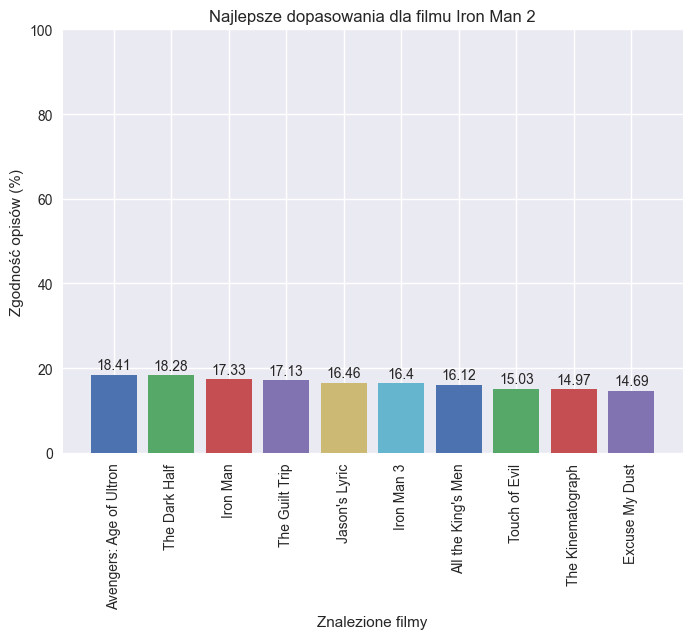

In [40]:
movie_title = 'Iron Man 2'
top_matches = find_similar_to(title=movie_title)
create_chart_for_matches(matches=top_matches, title=movie_title, save=True)